# Notebook 3: Grad-CAM — Visualizing "Attention" in Deep Learning (CNNs)

## What we are doing
**Deep learning** models for images are often called **"black boxes"**: we see the input (e.g., a photo of a dog) and the output (e.g., "Golden Retriever"), but we don't know **where** the model looked. Does it focus on the **object** (the dog) or on the **background** (grass, sky)?

## Why it matters
**Grad-CAM** (Gradient-weighted Class Activation Mapping) produces a **heatmap** over the image: **hot (red)** regions are where the model paid the most "attention" for its prediction. This lets us check if the model is looking at the right parts of the scene — and in a bonus example, we will see how the heatmap **shifts** when we ask "Why Cat?" vs "Why Dog?" for an image containing both.

In [3]:
# Setup: Install dependencies (run once)
!pip install torch torchvision grad-cam opencv-python matplotlib requests Pillow -q

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
# Imports
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# ImageNet class names (self-contained: fetch from stable URL)
IMAGENET_LABELS_URL = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
imagenet_labels = requests.get(IMAGENET_LABELS_URL, timeout=5).json()

---
## The "Black Box": Load model and get a prediction

We use a **pre-trained ResNet50** from PyTorch (trained on ImageNet). We will download an image, run it through the model, and print the **top-3** predicted classes — without any explanation of *where* the model looked.

In [5]:
# Load pre-trained ResNet50 and set to eval mode
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
model.eval()

# ImageNet preprocessing (normalize with ImageNet mean/std)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 214MB/s]


---
## The image: Golden Retriever (from a stable URL)

We download a single image from Wikimedia (or a similar stable URL) so the notebook is **self-contained** — no manual CSV or image download required.

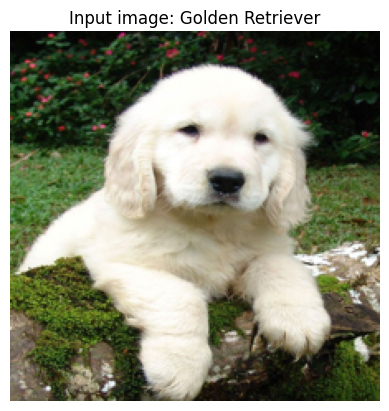

In [15]:
import requests
from PIL import Image
from io import BytesIO

url = "https://upload.wikimedia.org/wikipedia/commons/6/6e/Golde33443.jpg"

# Wikimedia requires a descriptive User-Agent
headers = {
    'User-Agent': 'MyImageDownloader/1.0 (contact: youremail@gmail.com)'
}

response = requests.get(url, headers=headers)

if response.status_code == 200:
    try:
        img_pil = Image.open(BytesIO(response.content)).convert("RGB")
        img_np = np.array(img_pil)
        # Resize to 224x224 for display consistency with model input
        img_display = np.array(Image.fromarray(img_np).resize((224, 224))) / 255.0

        plt.imshow(img_display)
        plt.axis("off")
        plt.title("Input image: Golden Retriever")
        plt.show()
    except Exception as e:
        print(f"PIL Error: {e}")
else:
    print(f"Download Failed: HTTP {response.status_code}")


In [16]:
# Preprocess for the model and get top-3 predictions
input_tensor = preprocess(img_pil).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)
    probs = torch.softmax(output, dim=1)
    top3_probs, top3_indices = torch.topk(probs[0], 3)

# imagenet_labels loaded above (index = class id)
print("Black-box prediction (top 3 classes):")
for i in range(3):
    idx = top3_indices[i].item()
    print(f"  {i+1}. {imagenet_labels[idx]}: {top3_probs[i].item():.2%}")

Black-box prediction (top 3 classes):
  1. Golden Retriever: 81.16%
  2. Kuvasz: 5.58%
  3. Pyrenean Mountain Dog: 5.33%


---
## The "Why": Grad-CAM heatmap

We use **Grad-CAM** on the **last convolutional block** of ResNet50 (`layer4`). The heatmap shows where the model "looked" to predict the top class. We overlay it on the original image: **red = highest activation**, **blue = lowest**.

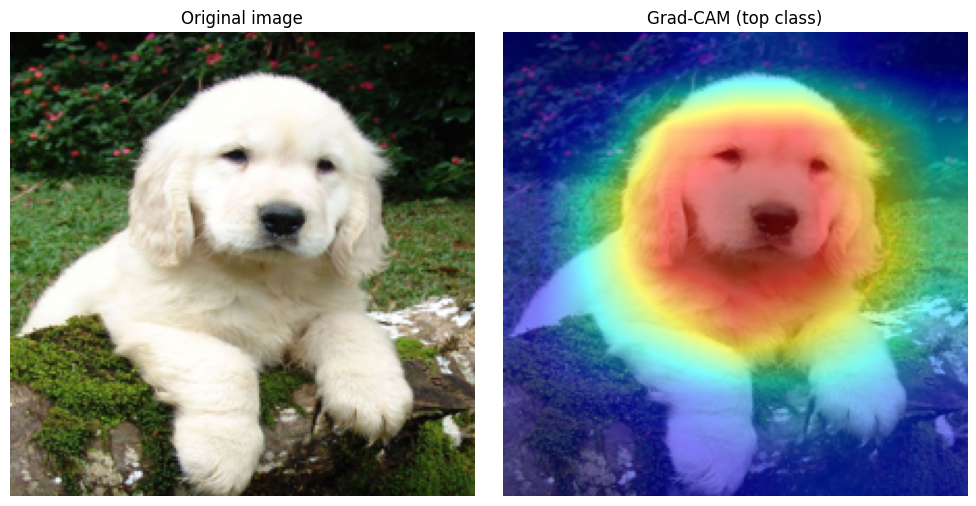

In [17]:
# Grad-CAM target: last layer of ResNet50's layer4 (standard choice for ResNet)
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# Target the top-predicted class (so we explain "why Golden Retriever?")
target_class = top3_indices[0].item()
targets = [ClassifierOutputTarget(target_class)]

# Generate CAM (input_tensor from above)
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0]

# Overlay on the display image (float [0,1])
cam_overlay = show_cam_on_image(img_display, grayscale_cam, use_rgb=True)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_display)
axes[0].set_title("Original image")
axes[0].axis("off")
axes[1].imshow(cam_overlay)
axes[1].set_title("Grad-CAM (top class)")
axes[1].axis("off")
plt.tight_layout()
plt.show()

### Insight: What the heatmap shows

Look at the heatmap: it is **hottest (red)** around the **dog's snout, ears, and head** — the discriminative parts of a Golden Retriever. The **grass and sky** stay **cool (blue/green)**. So the model is **not** relying on the background; it is focusing on the **right** features (the animal itself). This confirms that the CNN is "looking at" the object we care about, which builds trust in the prediction.

---
## Bonus: Cat and Dog in one image — class-specific attention

We download an image that contains **both** a cat and a dog. We run Grad-CAM **twice**:
1. Target the **Cat** class → heatmap should light up the **cat**.
2. Target the **Dog** class → heatmap should light up the **dog**.

This shows that the model **distinguishes** the two objects **spatially**; the explanation is **class-specific**.

In [21]:
import requests
from PIL import Image
from io import BytesIO

url_catdog = "https://upload.wikimedia.org/wikipedia/commons/thumb/5/58/Cat_and_Dog_Game.jpg/1280px-Cat_and_Dog_Game.jpg?20190207114454"

# Wikimedia requires a descriptive User-Agent
headers = {
    'User-Agent': 'MyImageDownloader/1.0 (contact: youremail@gmail.com)'
}

response_cd = requests.get(url_catdog, headers=headers)

if response.status_code == 200:
    try:
        img_catdog_pil = Image.open(BytesIO(response_cd.content)).convert("RGB")
        img_catdog_np = np.array(img_catdog_pil)
        img_catdog_display = np.array(Image.fromarray(img_catdog_np).resize((224, 224))) / 255.0
    except Exception as e:
        print(f"PIL Error: {e}")
else:
    print(f"Download Failed: HTTP {response.status_code}")


In [22]:
input_catdog = preprocess(img_catdog_pil).unsqueeze(0)

# ImageNet class indices: 281 = tabby cat, 207 = golden retriever (common examples)
# We use the top prediction for "cat-like" and "dog-like" or fixed indices
with torch.no_grad():
    out_cd = model(input_catdog)
    probs_cd = torch.softmax(out_cd, dim=1)
    top5 = torch.topk(probs_cd[0], 5)
# Find which of top-5 is cat vs dog (281=tabby, 282=persian, 207=golden retriever, etc.)
cat_idx = 281  # tabby cat
dog_idx = 207  # golden retriever

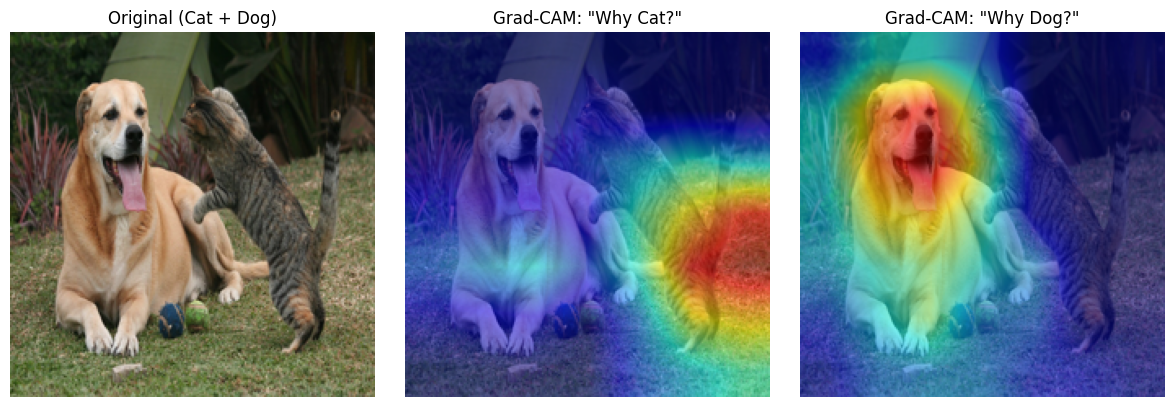

In [23]:
# Grad-CAM for "Why Cat?"
cam_cat = GradCAM(model=model, target_layers=target_layers)
grayscale_cam_cat = cam_cat(input_tensor=input_catdog, targets=[ClassifierOutputTarget(cat_idx)])[0]
overlay_cat = show_cam_on_image(img_catdog_display, grayscale_cam_cat, use_rgb=True)

# Grad-CAM for "Why Dog?"
grayscale_cam_dog = cam_cat(input_tensor=input_catdog, targets=[ClassifierOutputTarget(dog_idx)])[0]
overlay_dog = show_cam_on_image(img_catdog_display, grayscale_cam_dog, use_rgb=True)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(img_catdog_display)
axes[0].set_title("Original (Cat + Dog)")
axes[0].axis("off")
axes[1].imshow(overlay_cat)
axes[1].set_title('Grad-CAM: "Why Cat?"')
axes[1].axis("off")
axes[2].imshow(overlay_dog)
axes[2].set_title('Grad-CAM: "Why Dog?"')
axes[2].axis("off")
plt.tight_layout()
plt.show()

### Insight: Class-specific heatmaps

**Notice how the heatmap shifts:** When we ask *"Why is this a Cat?"* (targeting the cat class), the **red** region lights up **on the cat**. When we ask *"Why is this a Dog?"* (targeting the dog class), the **red** region lights up **on the dog**. The model **distinguishes both objects spatially** and uses different regions of the image for each class. Grad-CAM makes this explicit: explanations are **class-specific**, not just "what the model looked at" in general.